In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import joblib
import warnings; warnings.simplefilter('ignore')


In [25]:
df = pd.read_csv('../data/raw.csv')
print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Loaded 70692 rows and 22 columns.


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [27]:
## 3. Data Cleaning & Validation <a name="cleaning"></a>

### 3.1 Nulls & Basic Stats
print(df.isnull().sum())  # Expect no outright nulls in survey data
print(df.describe().T)    # Quick summary: check min/max ranges for plausibility

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
                        count       mean        std   min   25%   50%   75%  \
Diabetes_binary       70692.0   0.500000   0.500004   0.0   0.0   0.5   1.0   
HighBP                70692.0   0.563458   0.495960   0.0   0.0   1.0   1.0   
HighChol              70692.0   0.525703   0.499342   0.0   0.0   1.0   1.0   
CholCheck             70692.0   0.975259   0.155336   0.0   1.0   1.0   1.0   
BMI                 

In [28]:
binary_flags = ['HighBP','HighChol','CholCheck','Stroke','HeartDisease','DiffWalk','Diabetes_binary']
numeric_cols = [c for c in df.columns if df[c].dtype!='object' and c not in binary_flags]
invalid_cols = [c for c in numeric_cols if (df[c]==0).sum()>0]
print("Potential invalid-zero columns:", invalid_cols)

Potential invalid-zero columns: ['Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'MentHlth', 'PhysHlth', 'Sex']


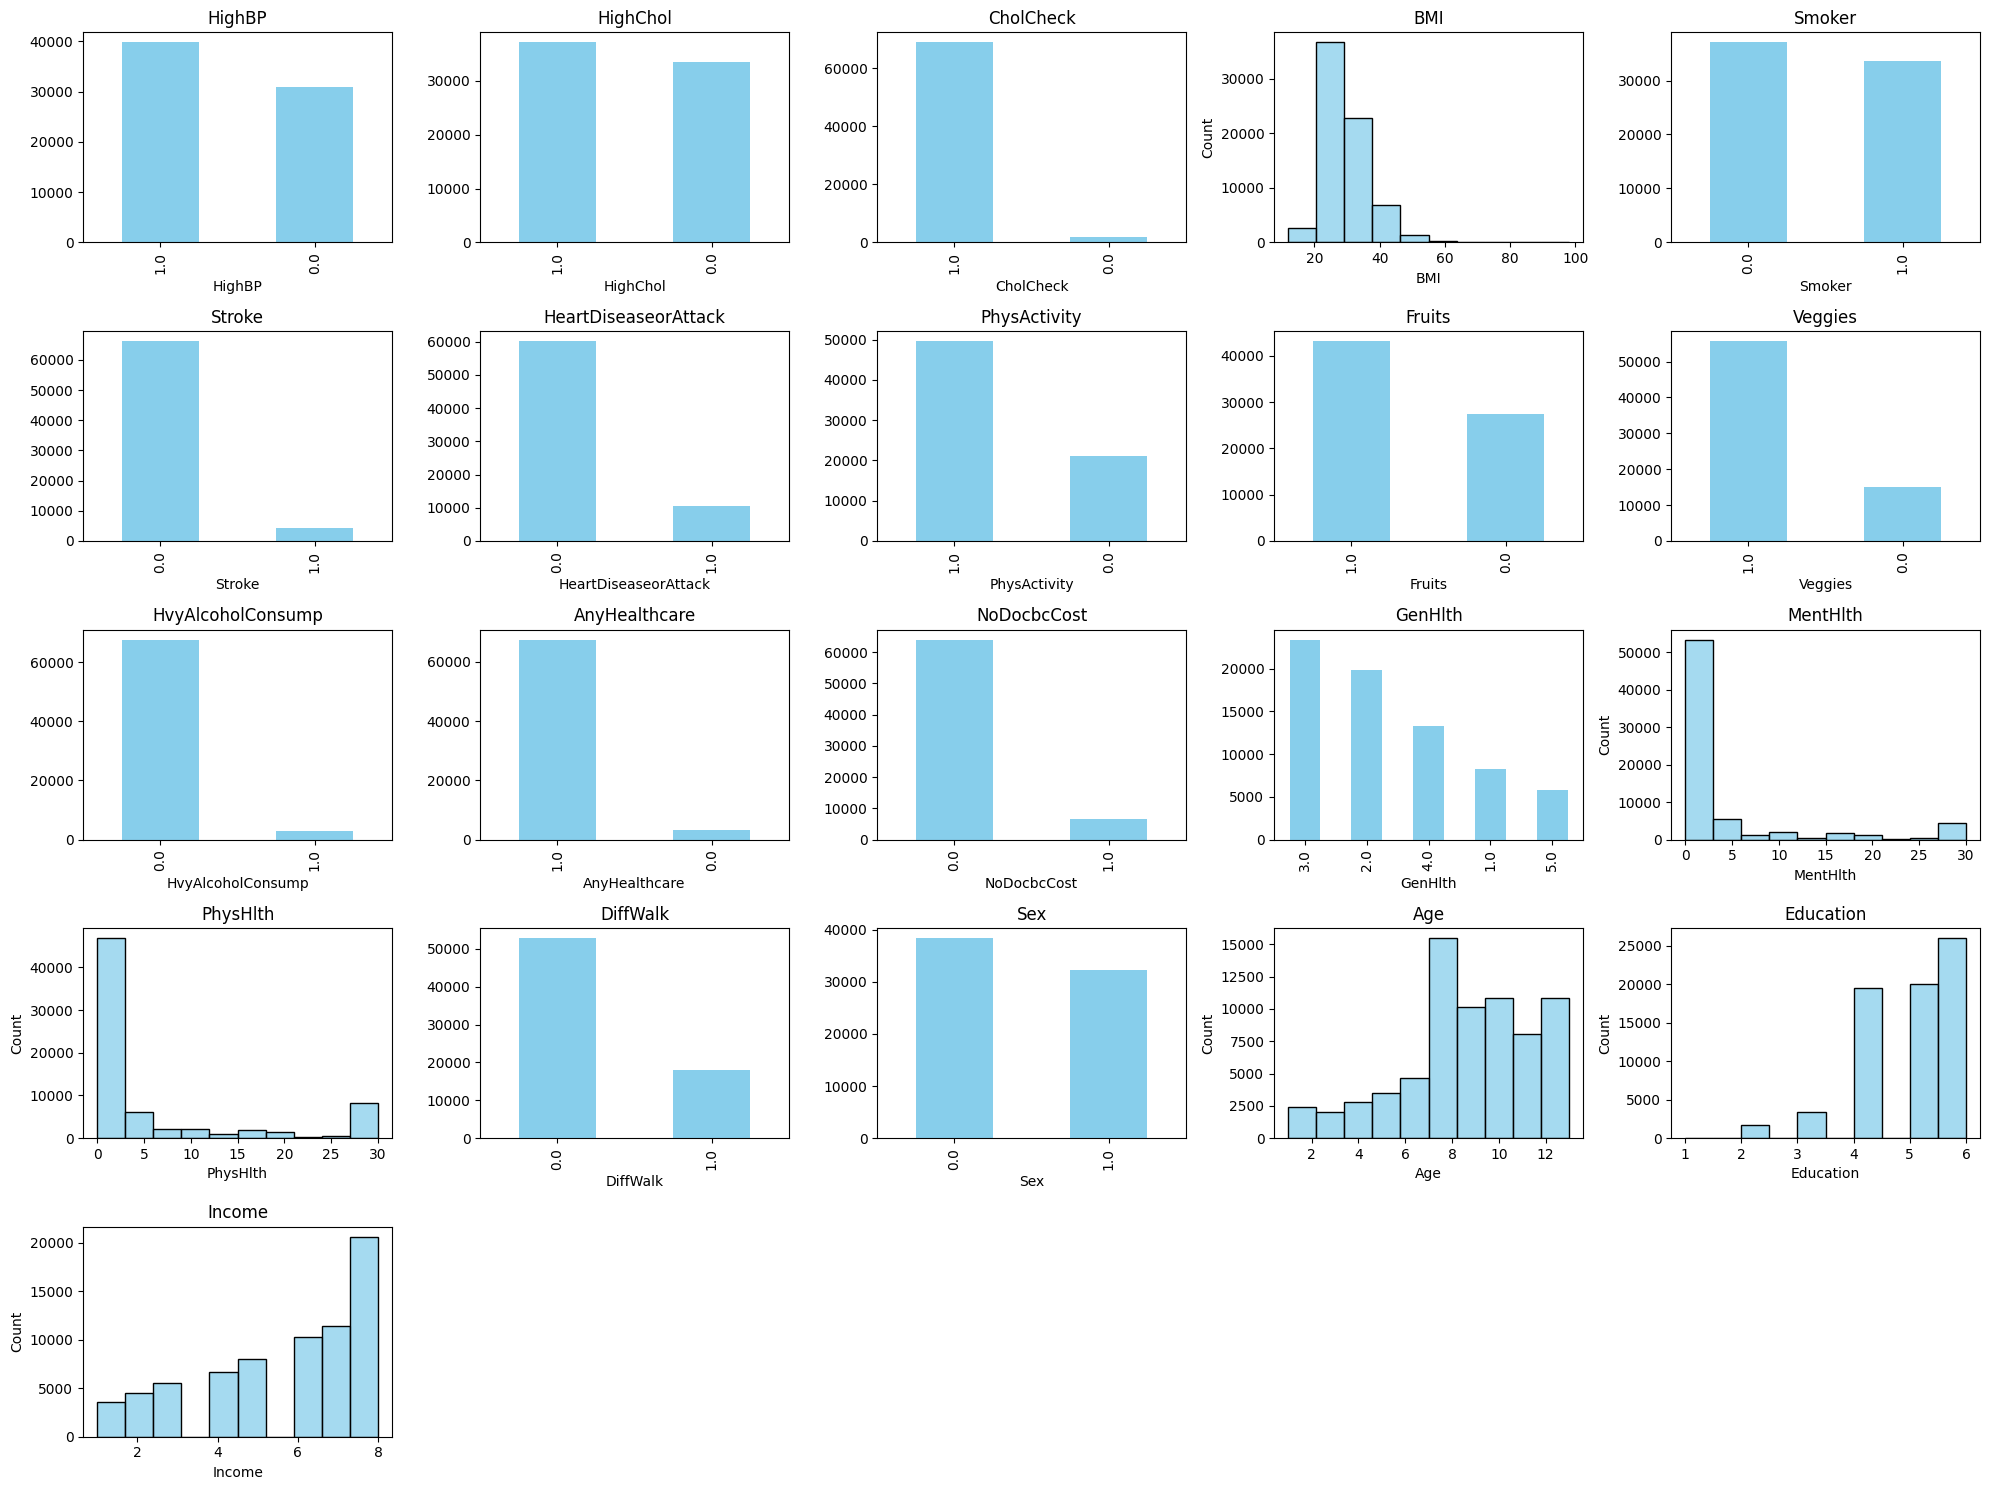

In [39]:
import math


features = df.columns.drop('Diabetes_binary')
num_features = len(features)

cols = 5
rows = math.ceil(num_features / cols)

plt.figure(figsize=(cols * 4, rows * 3))

for i, col in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    if df[col].nunique() > 5:
        sns.histplot(df[col], kde=False, bins=10, color='skyblue')
    else:
        df[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.show()


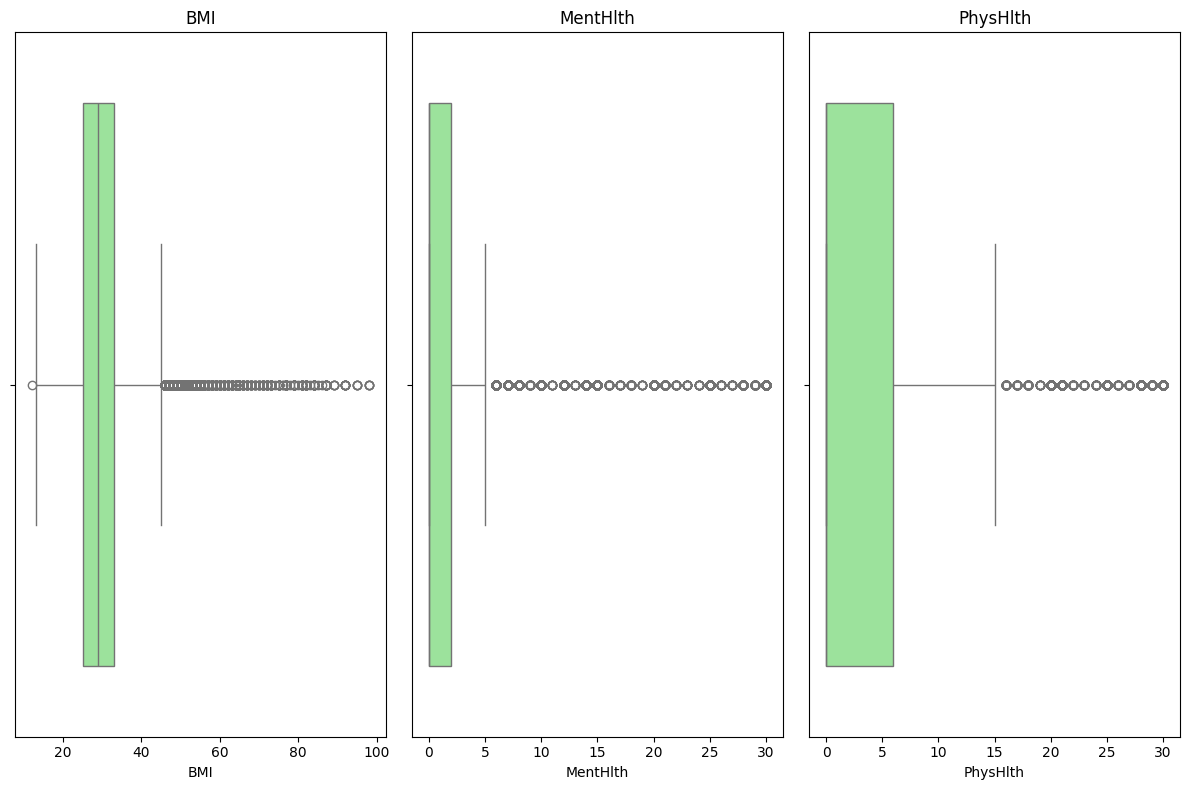

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(['BMI','MentHlth','PhysHlth'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(col)
plt.tight_layout()
plt.show()
# (Boxplots show some high outliers in BMI and health days)


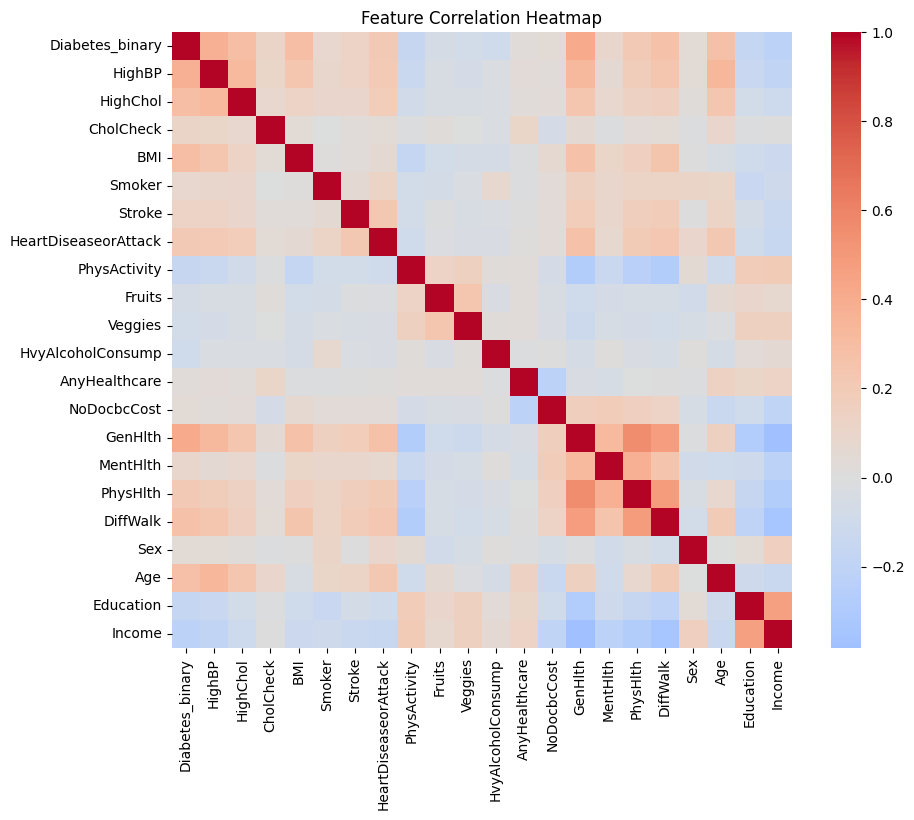

In [ ]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()
# (Heatmap reveals that features like HighBP and HeartDisease are positively correlated)


In [ ]:
grouped = df.groupby('Diabetes_binary').mean()
print(grouped[['BMI','HighBP','HighChol','HeartDiseaseorAttack','PhysActivity']].round(3))
#Diabetic patients have higher average BMI and much higher rates of high blood pressure and heart disease.

                    BMI  HighBP  HighChol  HeartDiseaseorAttack  PhysActivity
Diabetes_binary                                                              
0.0              27.770   0.374     0.381                 0.073         0.776
1.0              31.944   0.753     0.670                 0.223         0.631


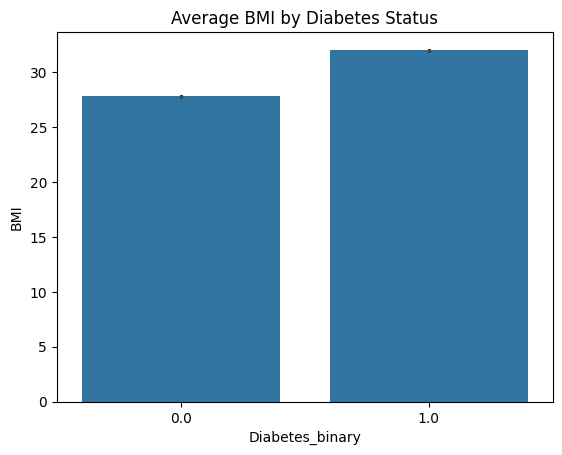

In [ ]:
sns.barplot(x='Diabetes_binary', y='BMI', data=df)
plt.title('Average BMI by Diabetes Status')
plt.show()
# (Diabetics have higher mean BMI)



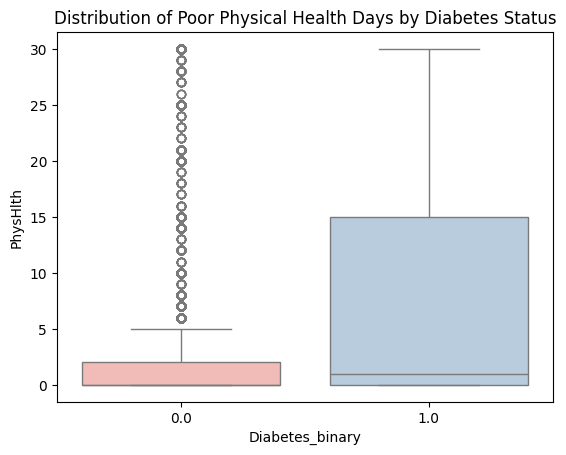

In [ ]:
sns.boxplot(x='Diabetes_binary', y='PhysHlth', data=df, palette='Pastel1')
plt.title('Distribution of Poor Physical Health Days by Diabetes Status')
plt.show()
# Diabetics tend to report more days of poor physical health.


In [48]:
from numpy import log1p
df_trans = df.copy()

#  Winsorize BMI (outlier handling at extremes)
q_low, q_high = df['BMI'].quantile(0.01), df['BMI'].quantile(0.99)
df_trans['BMI'] = df['BMI'].clip(q_low, q_high)

# Apply log1p to reduce skewness of MentHlth and PhysHlth
df_trans['MentHlth'] = log1p(df['MentHlth'])
df_trans['PhysHlth'] = log1p(df['PhysHlth'])


In [49]:
X = df_trans.drop(columns='Diabetes_binary')
y = df_trans['Diabetes_binary']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # fit on full data just for demonstration (normally fit on train only)


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC:", round(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]),3))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.73      0.74     10604
         1.0       0.74      0.77      0.75     10604

    accuracy                           0.75     21208
   macro avg       0.75      0.75      0.75     21208
weighted avg       0.75      0.75      0.75     21208

Confusion Matrix:
 [[7703 2901]
 [2435 8169]]
ROC AUC: 0.825


In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

for name, model in [("Decision Tree", dt), ("Random Forest", rf)]:
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),3))



Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66     10604
         1.0       0.66      0.65      0.65     10604

    accuracy                           0.66     21208
   macro avg       0.66      0.66      0.66     21208
weighted avg       0.66      0.66      0.66     21208

ROC AUC: 0.657

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73     10604
         1.0       0.72      0.77      0.75     10604

    accuracy                           0.74     21208
   macro avg       0.74      0.74      0.74     21208
weighted avg       0.74      0.74      0.74     21208

ROC AUC: 0.809


In [54]:
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC:", round(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]),3))


XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.71      0.74     10604
         1.0       0.73      0.79      0.76     10604

    accuracy                           0.75     21208
   macro avg       0.75      0.75      0.75     21208
weighted avg       0.75      0.75      0.75     21208

ROC AUC: 0.822


In [55]:
from sklearn.model_selection import cross_val_score
for name, model in [("Random Forest", rf), ("XGBoost", xgb)]:
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='roc_auc')
    print(f"{name} CV AUC scores: {scores.round(3)}, Mean = {scores.mean():.3f}")


Random Forest CV AUC scores: [0.799 0.809 0.807 0.815 0.814], Mean = 0.809
XGBoost CV AUC scores: [0.814 0.821 0.821 0.828 0.825], Mean = 0.822


In [72]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
rs = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, 
                        n_iter=5, cv=3, scoring='roc_auc', random_state=42)
rs.fit(X_train, y_train)
print("Best RF params:", rs.best_params_)
best_rf = rs.best_estimator_
print("Tuned RF ROC AUC:", round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]),3))


Best RF params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 10}
Tuned RF ROC AUC: 0.826


In [ ]:
# Define the parameter grid for Logistic Regression
param_grid = [
    {'penalty': ['l1','l2','none'], 
     'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['elasticnet'], 
     'C': [0.001, 0.01, 0.1, 1, 10, 100], 
     'l1_ratio': [0.5]}
]
# Initialize and run GridSearchCV with saga solver
logreg = LogisticRegression(solver='saga', max_iter=10000, random_state=42)
grid_lr = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Best parameters and ROC AUC on test set
print("Best LR params:", grid_lr.best_params_)
print(f"Tuned LR ROC AUC: {roc_auc_score(y_test, grid_lr.predict_proba(X_test)[:,1]):.4f}")


Best LR params: {'C': 0.01, 'penalty': 'l2'}
Tuned LR ROC AUC: 0.8251


In [ ]:
# Define parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(rf, param_dist, n_iter=20, 
                               scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Best parameters and ROC AUC on test set
print("Best RF params:", rf_random.best_params_)
print(f"Tuned RF ROC AUC: {roc_auc_score(y_test, rf_random.predict_proba(X_test)[:,1]):.4f}")

Best RF params: {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 10}
Tuned RF ROC AUC: 0.8261


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Base model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Broad random grid
param_dist_xgb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# RandomizedSearchCV (NO early stopping)
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    n_jobs=-1
)
xgb_random.fit(X_train, y_train)
print("Best XGB params (random):", xgb_random.best_params_)

# Narrow grid around best random search params
best_params = xgb_random.best_params_
param_grid_xgb = {
    'n_estimators': [best_params['n_estimators'] - 20, best_params['n_estimators'], best_params['n_estimators'] + 20],
    'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
    'learning_rate': [round(best_params['learning_rate'] * f, 3) for f in [0.5, 1.0, 1.5]],
    'subsample': [round(max(0.1, best_params['subsample'] - 0.1), 2), best_params['subsample'], round(min(1.0, best_params['subsample'] + 0.1), 2)],
    'colsample_bytree': [round(max(0.1, best_params['colsample_bytree'] - 0.1), 2), best_params['colsample_bytree'], round(min(1.0, best_params['colsample_bytree'] + 0.1), 2)],
}

# GridSearchCV (NO early stopping)
xgb_grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)
print("Best XGB params (grid):", xgb_grid.best_params_)


Best XGB params (random): {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best XGB params (grid): {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 170, 'subsample': 0.7}


In [ ]:

xgb_best = xgb_grid.best_estimator_
y_pred_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]

# Calculate ROC AUC on test set
test_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("Test ROC AUC Score (XGB - GridSearchCV):", round(test_auc_xgb, 4))

Test ROC AUC Score (XGB - GridSearchCV): 0.8304


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Extract best estimators
best_lr = grid_lr.best_estimator_
best_rf = rf_random.best_estimator_
best_xgb = xgb_grid.best_estimator_

# List of tuned models
models = [
    ("Tuned Logistic Regression", best_lr),
    ("Tuned Random Forest", best_rf),
    ("Tuned XGBoost", best_xgb)
]

# Evaluate each model
print("Model Evaluation on Test Set:\n")
for name, model in models:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    print(f"{name}:")
    print(f"  Accuracy   = {acc:.3f}")
    print(f"  Precision  = {prec:.3f}")
    print(f"  Recall     = {rec:.3f}")
    print(f"  F1 Score   = {f1:.3f}")
    print(f"  ROC AUC    = {roc:.3f}\n")


Model Evaluation on Test Set:

Tuned Logistic Regression:
  Accuracy   = 0.748
  Precision  = 0.738
  Recall     = 0.770
  F1 Score   = 0.754
  ROC AUC    = 0.825

Tuned Random Forest:
  Accuracy   = 0.749
  Precision  = 0.727
  Recall     = 0.799
  F1 Score   = 0.761
  ROC AUC    = 0.826

Tuned XGBoost:
  Accuracy   = 0.753
  Precision  = 0.731
  Recall     = 0.800
  F1 Score   = 0.764
  ROC AUC    = 0.830



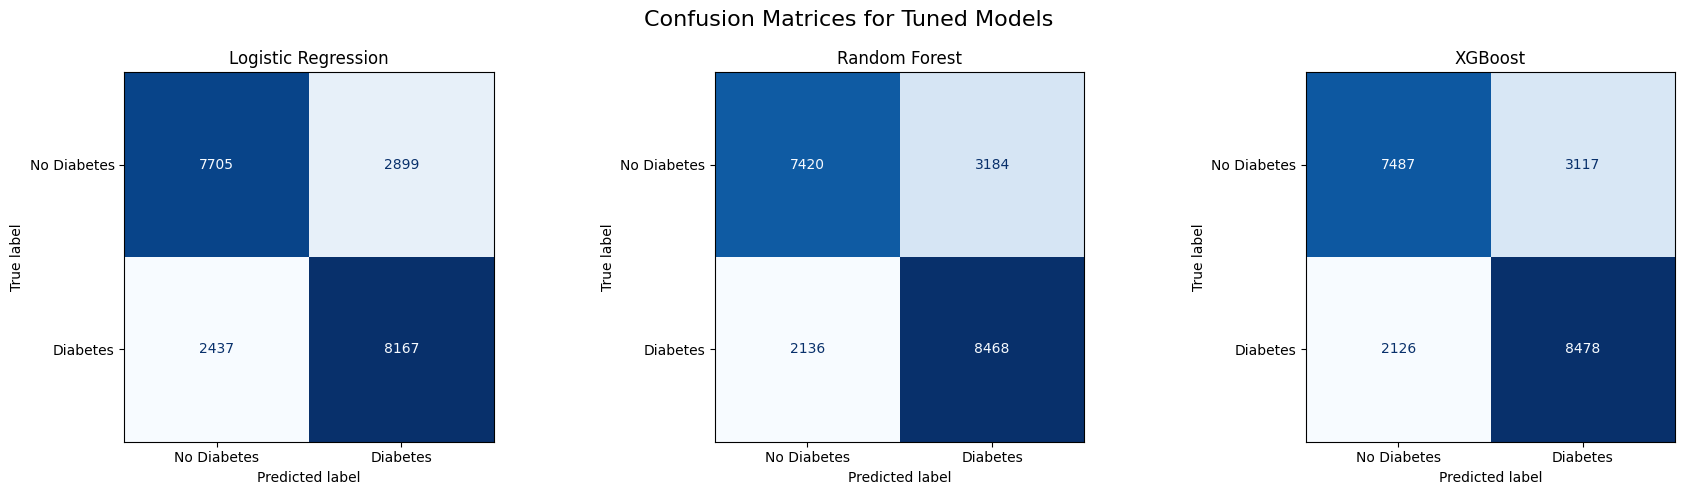

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# List of models
models = [
    ("Logistic Regression", best_lr),
    ("Random Forest", best_rf),
    ("XGBoost", best_xgb)
]

# Plot confusion matrix for each model
for ax, (name, model) in zip(axes, models):
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=["No Diabetes", "Diabetes"],
        cmap="Blues",
        ax=ax,
        colorbar=False
    )
    ax.set_title(name)

plt.suptitle("Confusion Matrices for Tuned Models", fontsize=16)
plt.tight_layout()
plt.show()


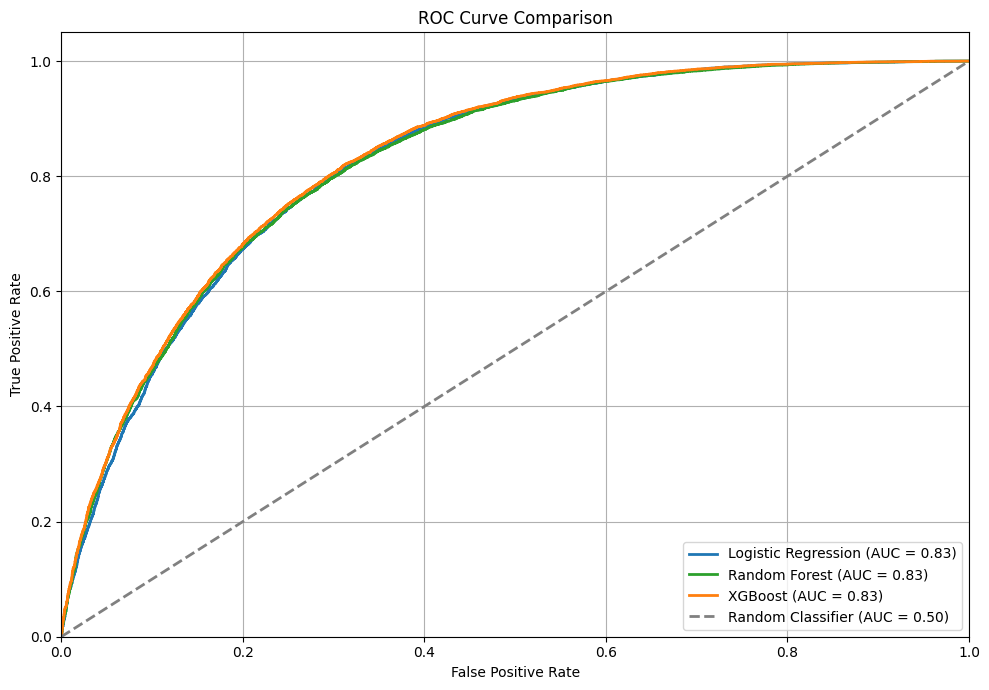

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot with distinct colors
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', color='#1f77b4', lw=2)   # Blue
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='#2ca02c', lw=2)         # Green
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', color='#ff7f0e', lw=2)            # Orange

# Diagonal reference line
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')

# Labels and styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
for i, imp in enumerate(best_xgb.feature_importances_):
    print(f"Feature {i}: {imp}")


Feature 0: 0.4198285937309265
Feature 1: 0.08175428211688995
Feature 2: 0.02291160635650158
Feature 3: 0.06246937811374664
Feature 4: 0.004522654227912426
Feature 5: 0.01169082522392273
Feature 6: 0.03426171839237213
Feature 7: 0.004605034366250038
Feature 8: 0.00414562551304698
Feature 9: 0.004866840783506632
Feature 10: 0.019154364243149757
Feature 11: 0.004356201738119125
Feature 12: 0.003137758234515786
Feature 13: 0.17026668787002563
Feature 14: 0.006204485893249512
Feature 15: 0.012029100209474564
Feature 16: 0.04212354123592377
Feature 17: 0.017353573814034462
Feature 18: 0.04889700561761856
Feature 19: 0.00834912620484829
Feature 20: 0.017071574926376343


100%|===================| 21180/21208 [02:41<00:00]        

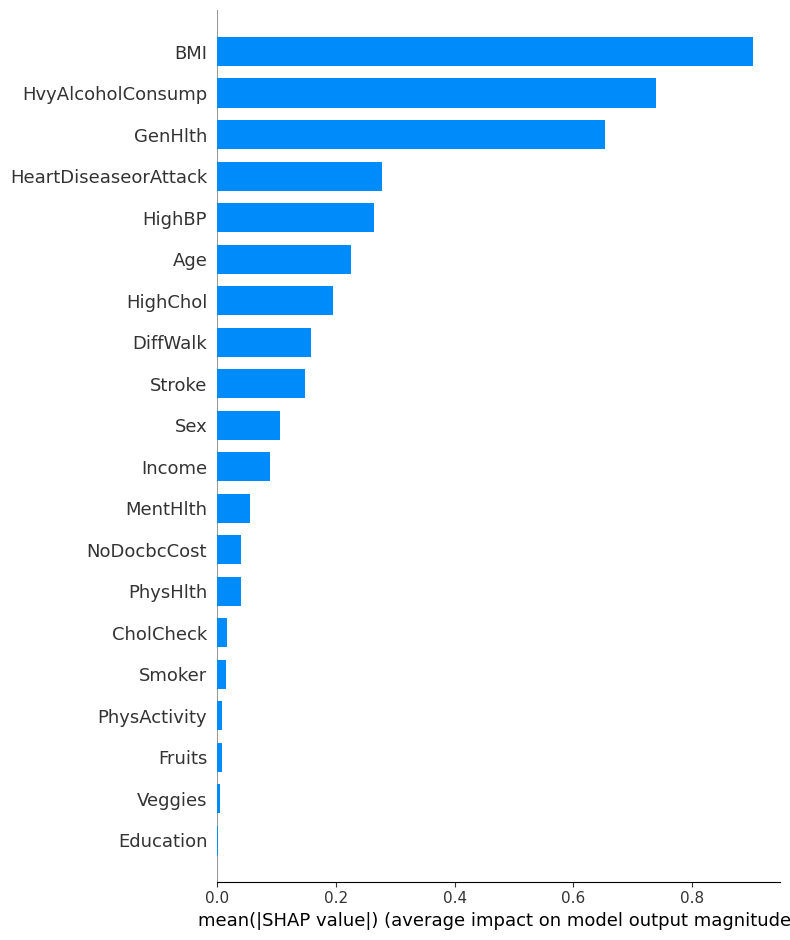

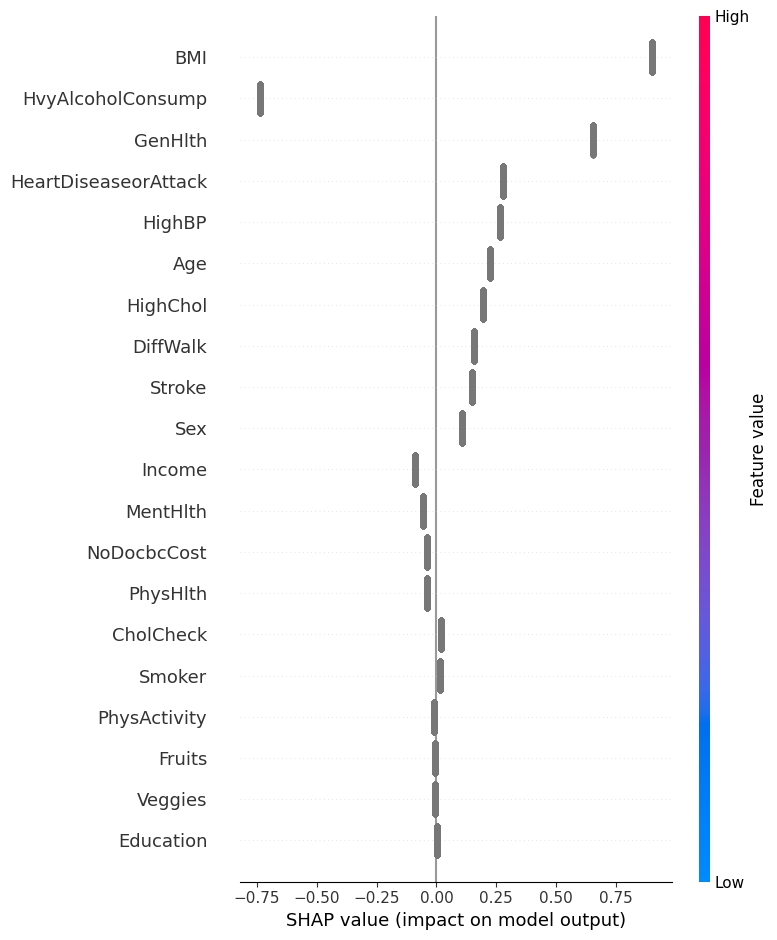

In [ ]:
column_names = ['HighBP','HighChol','CholCheck','BMI','Smoker','Stroke','HeartDiseaseorAttack',
                'PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare',
                'NoDocbcCost','GenHlth','MentHlth','PhysHlth','DiffWalk','Sex','Age',
                'Education','Income']


import shap

# Ensure your XGBoost model is fitted
explainer = shap.Explainer(best_xgb, X_train)  
shap_values = explainer(X_test)  


# Summary plot of feature impact
shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)






🔍 Waterfall Plot for Test Instance 0


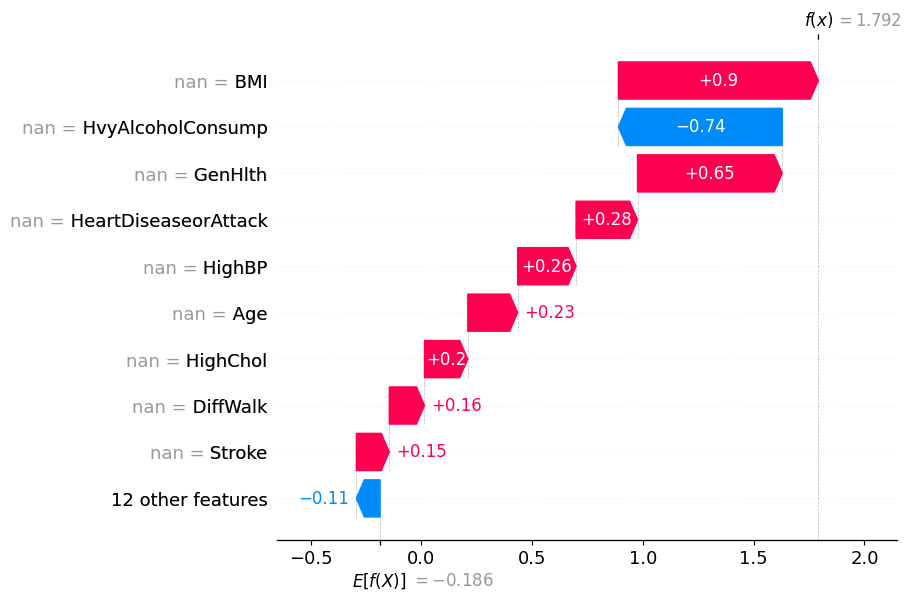


🔍 Waterfall Plot for Test Instance 1


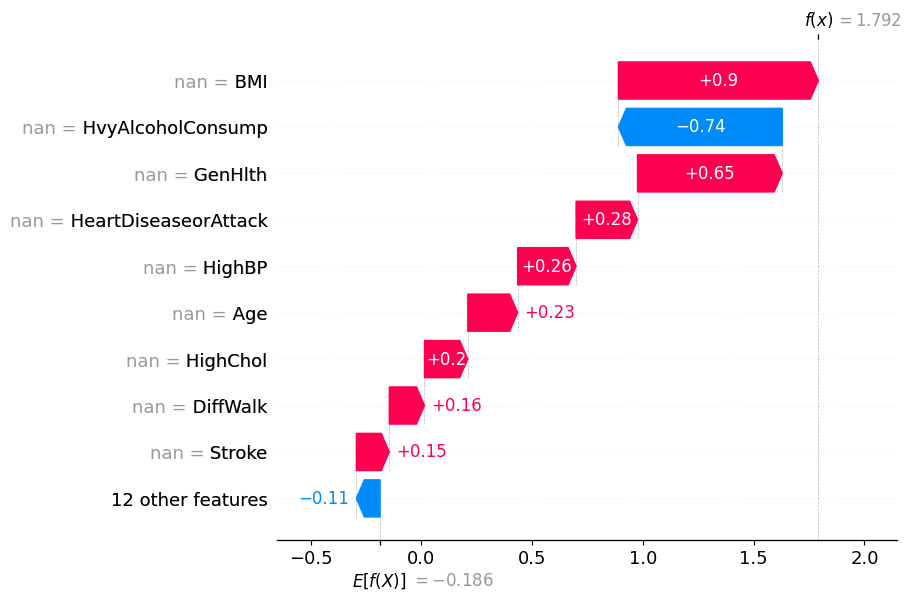


🔍 Waterfall Plot for Test Instance 2


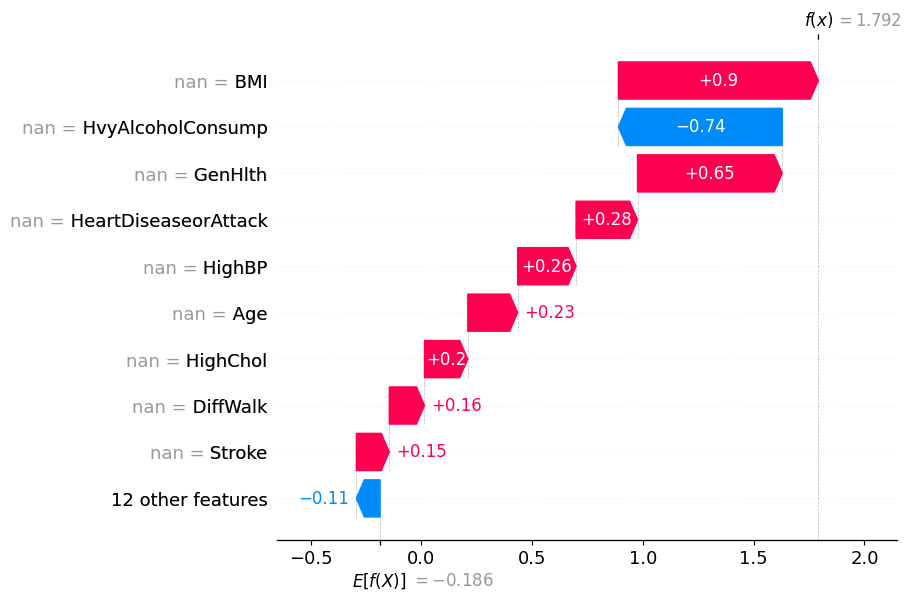


🔍 Waterfall Plot for Test Instance 3


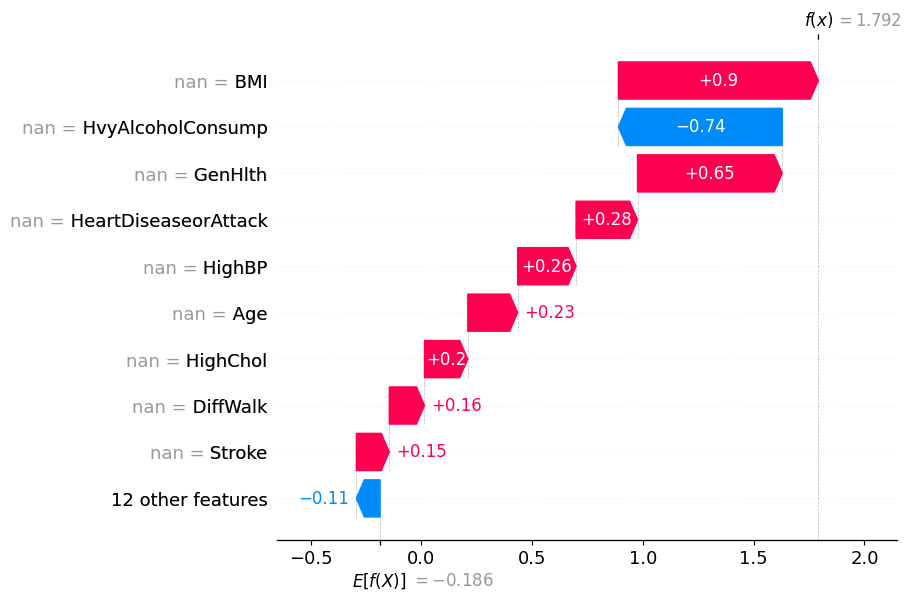


🔍 Waterfall Plot for Test Instance 4


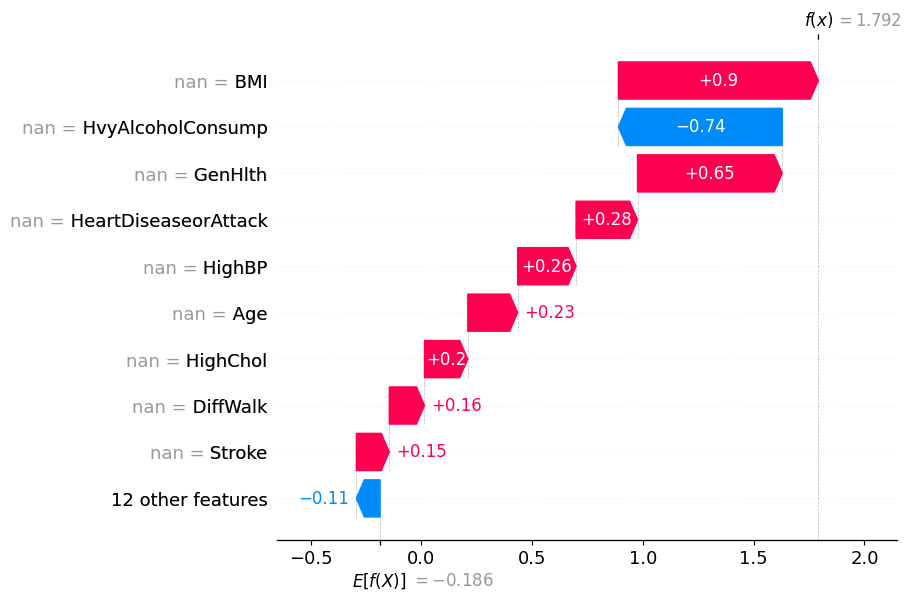

In [ ]:
for i in range(5):
    print(f"\n🔍 Waterfall Plot for Test Instance {i}")
    shap.plots.waterfall(shap_values[i], max_display=10)


In [ ]:

joblib.dump(best_xgb, '../model/best_xgb_model.pkl')

['../model/best_xgb_model.pkl']

In [ ]:
best_xgb = joblib.load('../model/best_xgb_model.pkl')
